# Camera Calibration
The code in this notebook will later be broken apart into separate packages. Currently, this notebook is for prototyping.

Starting the experimentation with the test images.

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import glob
from os import path
%matplotlib inline

In [2]:
"""
Calibrate the camera given a directory containing calibration chessboards.

param dir: directory containing chessboard frames
param nx: Chessboard corners on x axis
param ny: Chessboard corners on y axis
param img_prefix: The repeating prefix used to name calibration images
param img_type: Calibration image filetype
param verbose: if True, draw and show chessboard corners
return: calibration parameters
"""
def camera_calibration(dir="camera_cal", nx=9, ny=6, img_prefix = "", img_type="jpg", verbose=False):
    assert path.exists(dir), dir + " does not exist. Need a valid directory containing calibration images"
    # 3d points in real world space
    objpoints = []
    # 2d points in image plane
    imgpoints = []
    
    #prep objpoints so it looks like (0, 0, 0), (1, 0, 0), ... (nx, ny, 0)
    # the z coordinate is always zero
    objp = np.zeros((nx*ny, 3), np.float32)
    
    # mgrid returns the coordinate values for a given grid size --> [nx, ny]
    # we are shaping the coordinates from mgrid back into 2 columns --> (x, y)
    # this is to create image points, look at distorted calibration image and detect corners
    # of board
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    
    images = glob.glob(path.join(dir,img_prefix+"*."+img_type))
    
    assert len(images) > 0, "There are no images to calibrate the camere."
    
    for file in images:
        img = cv2.imread(file)
        # convert images to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # find corners, if they exist
        ret, corners = cv2.findChessboardCorners(img, (nx, ny), None)
        
        # if corners were detected, append the points to imgpoints, and objp to objpoints
        if ret:
            # print("Adding image and object points")
            # print(len(corners))
            # print(len(objp))
            imgpoints.append(corners)
            objpoints.append(objp)
            # displaying images if verbose option was set
            if verbose:
                img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
                plt.imshow(img)
                plt.show()
        
    # print(len(objpoints))
    # print(len(imgpoints))
        
    # returning hte calibration parameters
    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [3]:
"""
Undistort the images in the given directory.

param mtx: Camera Matrix
param dist: Distortion Coefficients
param dir: directory containing chessboard frames
param img_prefix: The repeating prefix used to name distorted images
param img_type: Distorted image filetype
"""
def undistort_images(mtx, dist, dir="test_images", img_prefix = "", img_type="jpg"):
    assert path.exists(dir), dir + " does not exist. Need a valid directory containing distorted images"
    
    # reading all filenames of distorted images
    images = glob.glob(path.join(dir, img_prefix + "*." + img_type))
    assert len(images) > 0, "There are no images to undistort the camere."
    
    for file in images:
        img = cv2.imread(file)
        undistort = cv2.undistort(img, mtx, dist, None, mtx)
        
        fig, ax = plt.subplots(nrows=1, ncols=2)
        ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax[1].imshow(cv2.cvtColor(undistort, cv2.COLOR_BGR2RGB))
        plt.show()

"""
Undistort the given image.

param img: Distorted Image
param mtx: Camera Matrix
param dist: Distortion Coefficients
return: Undistorted Image
"""
def undistort_image(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)


# Displaying the Calibration Images with Corners Drawn

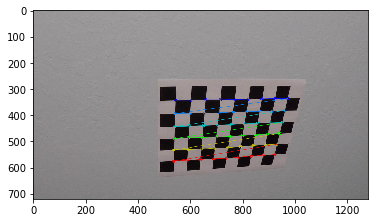

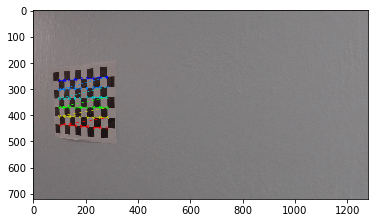

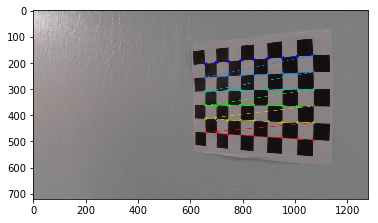

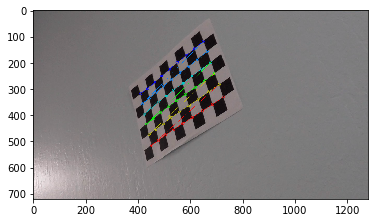

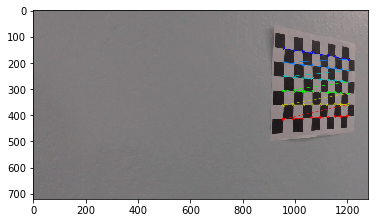

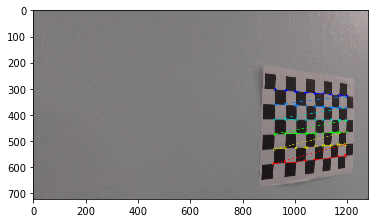

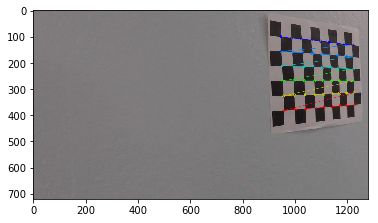

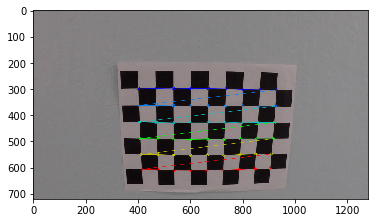

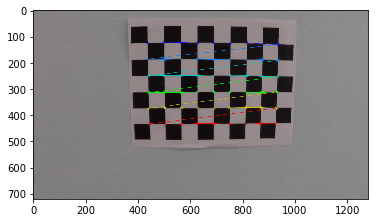

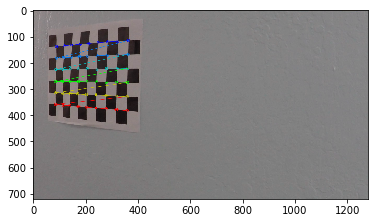

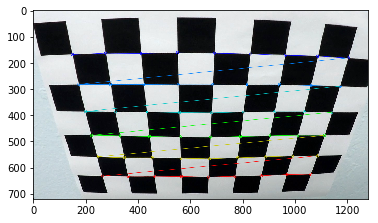

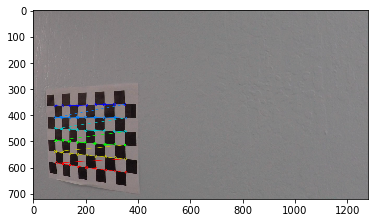

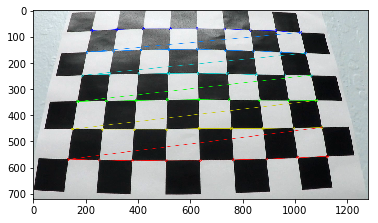

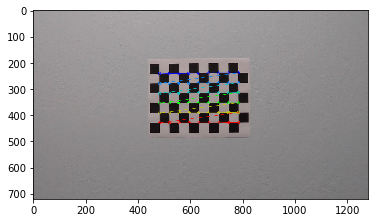

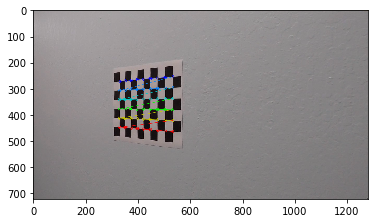

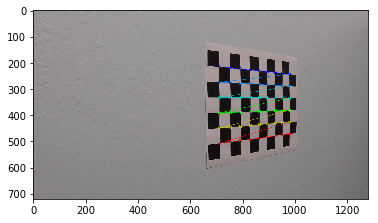

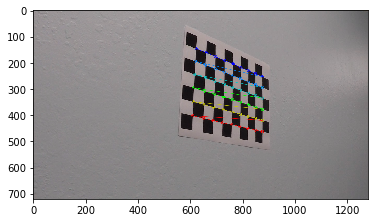

In [4]:
ret, mtx, dist, rvecs, tvecs = camera_calibration(verbose=True)

# Displaying undistorted images

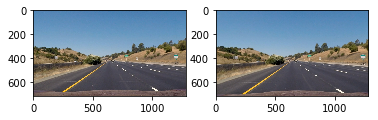

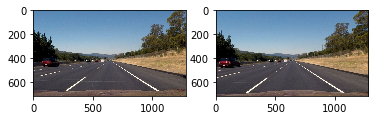

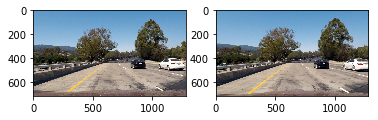

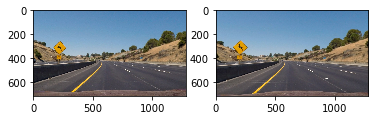

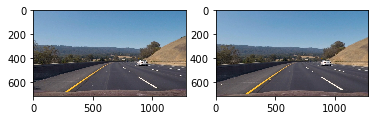

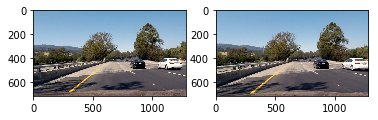

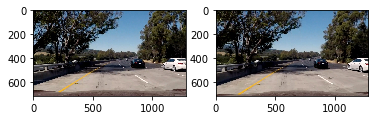

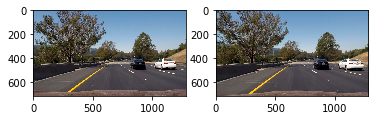

In [5]:
undistort_images(mtx, dist)

# Image Thresholding
Going to implement image thresholding here. This will be used to find the lanes.

In [6]:
"""
Acquires the Sobel Gradient

param gray: grayscale image
param thres: Tuple containing threshold values in range [0, 255]
param kernel: kernel size for sobel operation
return: Binary image  
"""
def Sobel(gray, thres = (20, 100), kernel = 3):
    # Sobel Gradient 
    x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = kernel)
    y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = kernel)
    
    abs_sobelx = np.absolute(x)
    abs_sobely = np.absolute(y)
    
    # rescaling to 8 bit
    scaled_sobelx = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    # print(scaled_sobelx.shape)
    scaled_sobely = np.uint8(255 * abs_sobely / np.max(abs_sobely))
    # print(scaled_sobely.shape)
    
    sobel_binx = np.zeros_like(scaled_sobelx)
    sobel_binx[((scaled_sobelx >= thres[0]) & (scaled_sobelx <= thres[1]))] = 1
    
    sobel_biny = np.zeros_like(scaled_sobely)
    sobel_biny[((scaled_sobely >= thres[0]) & (scaled_sobely <= thres[1]))] = 1
    
    return sobel_binx, sobel_biny
    
"""
Acquires the Magnitude of the  Gradient

param gray: grayscale image
param thres: Tuple containing threshold values in range [0, 255]
param kernel: kernel size for sobel operation
return: Binary image  
"""
def Magnitude(gray, thres = (20, 100), kernel = 3):
    # Sobel Gradient 
    x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = kernel)
    y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = kernel)
    
    # Gradient Magnitude
    magnitude = np.sqrt(x**2 + y**2)
    
    # rescaling to 8 bit
    scaled_magnitude = np.max(magnitude)/255
    magnitude = np.uint8(magnitude / scaled_magnitude)
    # print(magnitude.shape)
    mag_bin = np.zeros_like(magnitude)
    mag_bin[((magnitude >= thres[0]) & (magnitude <= thres[1]))] = 1
    return mag_bin

"""
Acquires the Direction of the Gradient

param gray: grayscale image
param thres: Tuple containing threshold values in range [0, 255]
param kernel: kernel size for sobel operation
return: Binary image  
"""
def Direction(gray, thres = (0.7, 1.3), kernel = 15):
    # Sobel Gradient 
    x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = kernel)
    y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = kernel)
    
    # Gradient Direction
    direction = np.arctan2(np.absolute(y), np.absolute(x))
    dir_bin = np.zeros_like(direction)
    dir_bin[((direction >= thres[0]) & (direction <= thres[1]))] = 1
    return dir_bin

"""
Combine Thresholds, excluding S channel

param sobelx: Sobel Binary on X axis
param sobely: Sobel Binary on Y axis
param magnitude: Magnitude of Gradient
param direction: Direction of Gradient
param verbose: If True, displays all inputs and output
return: Binary Image 
"""
def Combine(sobelx, sobely, magnitude, direction, verbose = False):
    # print(direction.shape)
    output = np.zeros_like(direction)
    output[(((sobelx == 1) & (sobely == 1)) | ((magnitude == 1) & (direction == 1)))]= 1
    
    if verbose:
        fig, ax = plt.subplots(nrows=1, ncols=2)
        ax[0].imshow(sobelx, cmap = "gray")
        ax[0].set_title("sobel_binx")
        ax[1].imshow(sobely, cmap = "gray")
        ax[1].set_title("sobel_biny")
        fig2, ax2 = plt.subplots(nrows=1, ncols=2)
        ax2[0].imshow(magnitude, cmap = "gray")
        ax2[0].set_title("magnitude")
        ax2[1].imshow(direction, cmap = "gray")
        ax2[1].set_title("direction")
        fig3, ax3 = plt.subplots(nrows=1, ncols=1)
        ax3.imshow(output, cmap = "gray")
        ax3.set_title("Gradient Binary")
        plt.show()
        
    return output

In [7]:
"""
Isolates the S channel in HLS space, and returns a binary image.

param img: BGR image
param verbose: If True, displays the binary image
return: Binary image with S channel isolated
"""
def colorThresh(img, thresS = (90, 255), verbose = False):
    #hls
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    # isolating the S channel
    S = hls[:,:,2]
    S_bin = np.zeros_like(S)
    S_bin[((S >= thresS[0]) & (S <= thresS[1]))] = 1
    
    # selected threshold to highlight yellow lines
    yellow_min = np.array((0, 70, 70))
    yellow_max = np.array((50, 255, 255))
    
    #hsv
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    min_yellow = np.all(hsv > yellow_min, axis=2)
    max_yellow = np.all(hsv < yellow_max, axis=2)

    yellow = np.logical_and(min_yellow, max_yellow)
    
    # selected threshold to highlight yellow lines
    white_min = np.array((0, 0, 200))
    white_max = np.array((255, 20, 255))
    
    min_white = np.all(hsv > white_min, axis=2)
    max_white = np.all(hsv < white_max, axis=2)

    white = np.logical_and(min_white, max_white)
    
    out = np.zeros_like(S_bin)
    out[((yellow == 1) | (S_bin == 1) | (white == 1))] = 1

    if verbose:
        fig, ax = plt.subplots(nrows=1, ncols=2)
        ax[0].imshow(S, cmap = "gray")
        ax[0].set_title("S Channel")
        ax[1].imshow(S_bin, cmap = "gray")
        ax[1].set_title("S Channel Isolated Binary")
        plt.show()
        
        
        fig, ax = plt.subplots(nrows=1, ncols=2)
        ax[0].imshow(out, cmap = "gray")
        ax[0].set_title("out")
        ax[1].imshow(yellow, cmap = "gray")
        ax[1].set_title("yellow")
        plt.show()
        
    return out

In [8]:
"""
Transforms input image to highlight the lanes lines as much as possible

param img: undistorted image
param verbose: if True, visualize transformation process
return: binary image
"""
def transform_image(img, thresS = (90, 255), verbose = False):
    height, width = img.shape[:2]
    
    #grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    sobelx, sobely = Sobel(gray, thres = (20, 100), kernel = 3)
    magnitude = Magnitude(gray, thres = (30, 100), kernel = 3)
    direction = Direction(gray, kernel = 15)
    color = colorThresh(img, thresS = thresS, verbose=verbose)
    gradient = Combine(sobelx, sobely, magnitude, direction, verbose = verbose)
    
    combined = np.zeros_like(gradient)
    combined[((gradient == 1) | (color == 1))] = 1
    
    if verbose:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Input")
        plt.show()
        plt.imshow(combined, cmap = "gray")
        plt.title("Thresholded Binary")
        plt.show()
        
    return combined

# Perspective Transform
I am implementing perspective transform here to get a bird's eye view of the road.

In [9]:
"""
Applies a perspective transform to the provided image.

param img: Undistorted image
param verbose: If True, will display transformed image
return: Warped image
"""
def perspective_transform(img, verbose = False):
    # defining calibration box in source and destination coordinates
    # height, width
    height, width = img.shape[:2]
    
    # print(img_size)
    offset_y = 10
    
    # 4 source coordinates for transform
    p1 = [728, 460] # topRx, topRy INC
    p2 = [width, height - offset_y]# bottomRx, bottomRy
    p3 = [0, height - offset_y]# bottomLx, bottomLy
    p4 = [550, 460]# topLx, topLy DEC
    
    # the source points for the lane lines 
    src = np.float32([p1, p2, p3, p4])
    
    # the destination points that define how the new image should look
    # [350, 350], [930, 720], [350, 720], [930, 350]
    dst = np.float32([[width, 0],
                      [width, height],
                      [0, height],
                      [0, 0]])

    
    M = cv2.getPerspectiveTransform(src, dst)
    
    # applies a transform to the original image
    warped =  cv2.warpPerspective(img, M, (width, height), flags = cv2.INTER_LINEAR)
    
    if verbose:
        # print(warped.shape)
        # plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY))
        plt.imshow(warped, cmap = "gray")
        plt.title("Bird's Eye View")
        plt.show()
    
    return warped

In [16]:
"""
Returns a Column-wise Sum of pixels in binary image.

param img: Binary, Transformed Image
param divisor: Specifies which lower fraction of image to return histogram of
return: Array of pixel xount per column
"""
def Histogram(img, divisor = 2):
    return np.sum(img[np.int(img.shape[0]/divisor):,:], axis=0)

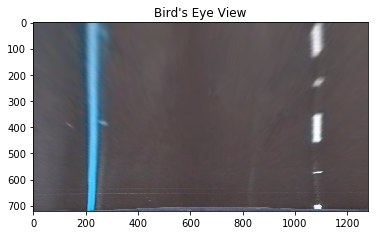

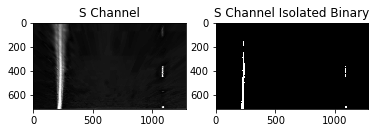

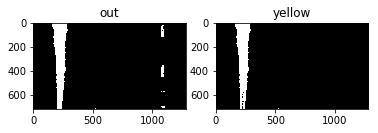

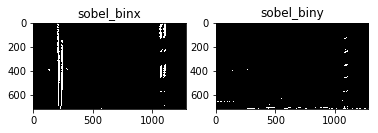

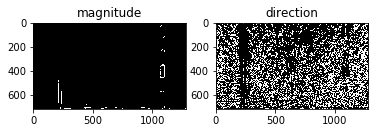

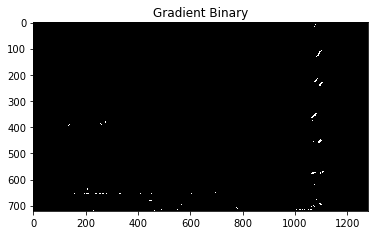

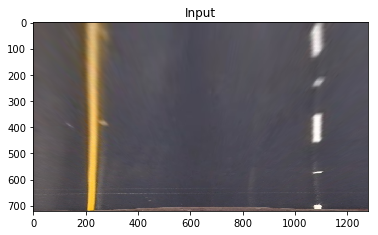

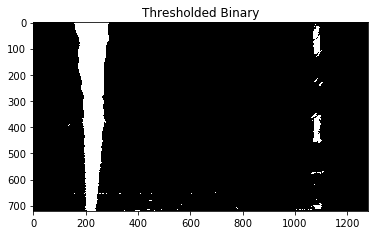

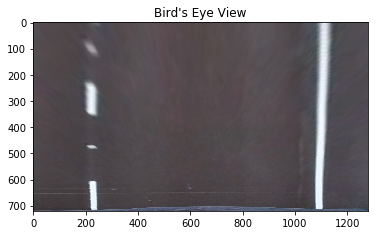

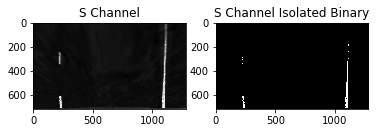

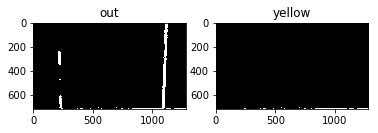

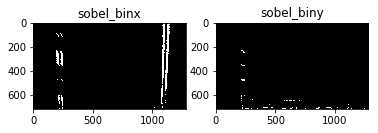

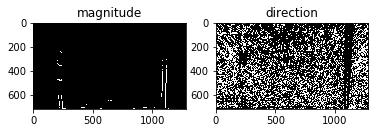

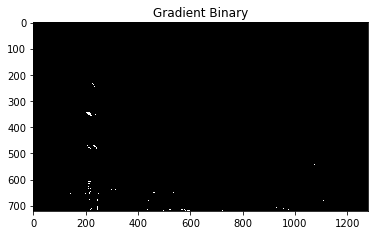

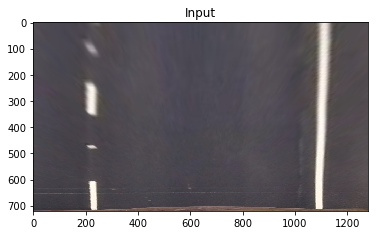

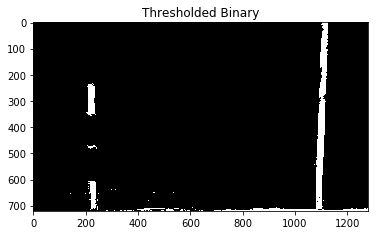

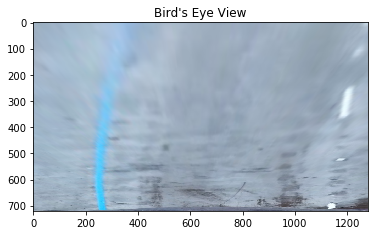

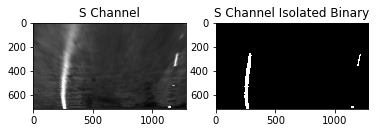

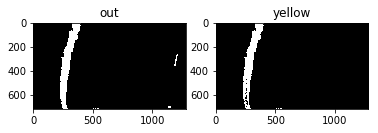

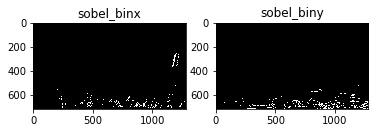

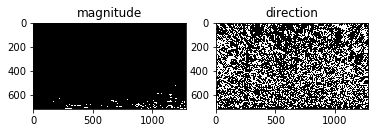

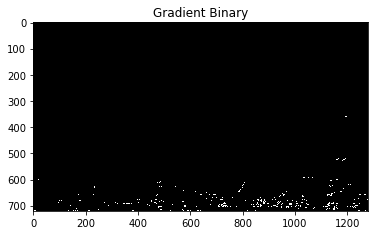

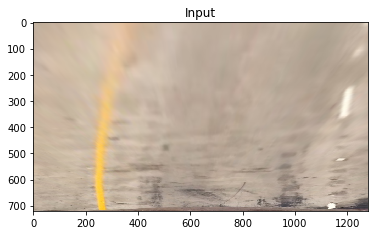

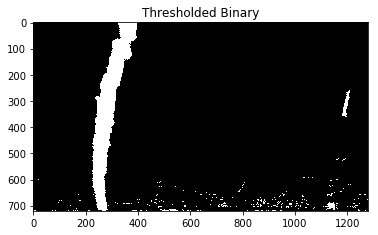

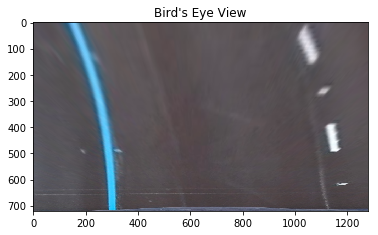

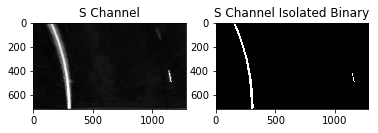

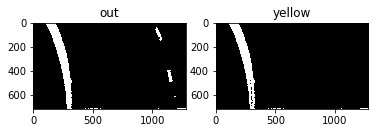

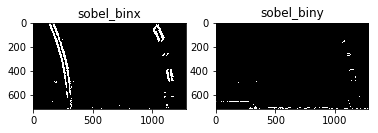

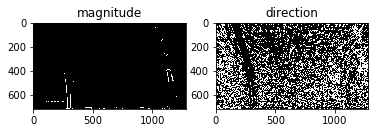

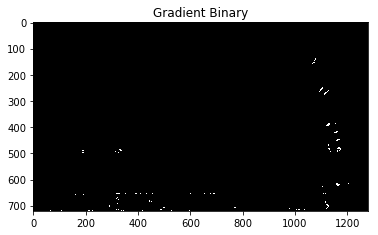

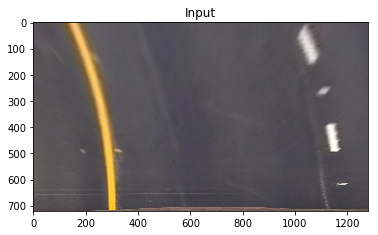

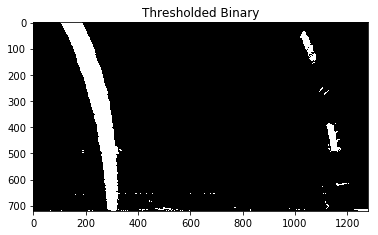

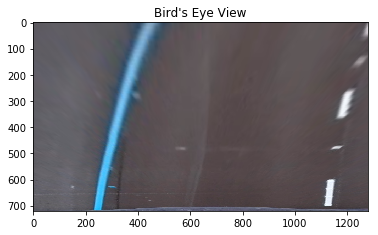

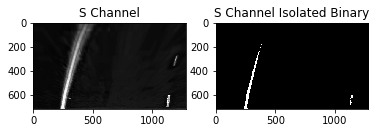

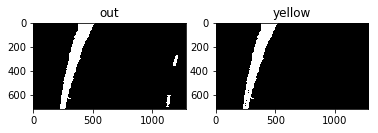

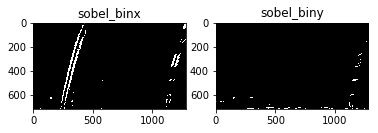

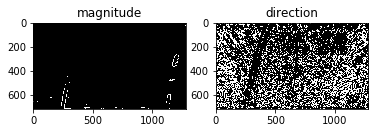

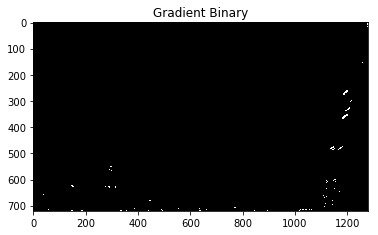

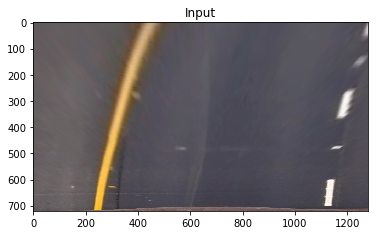

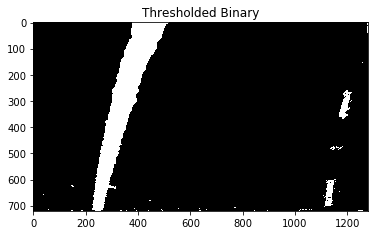

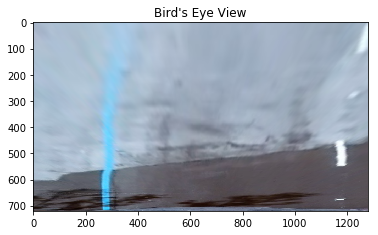

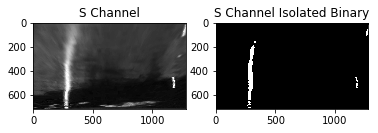

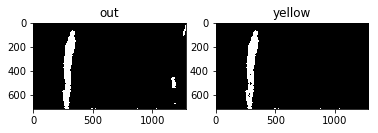

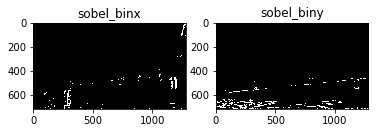

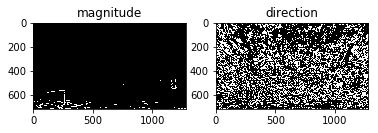

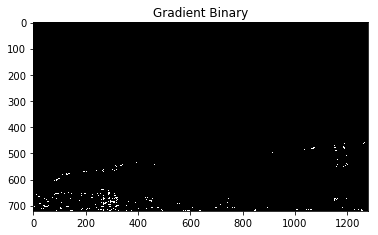

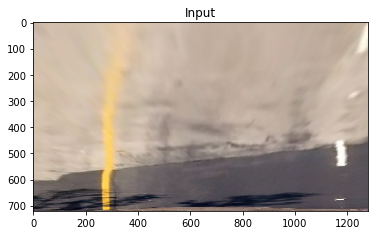

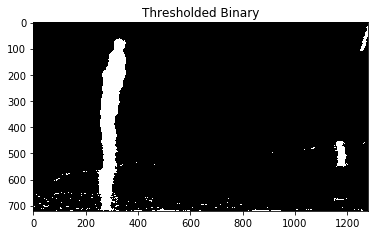

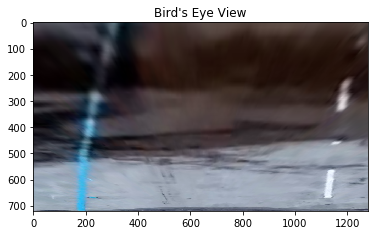

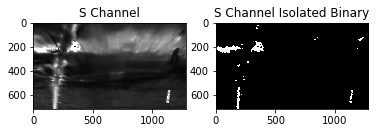

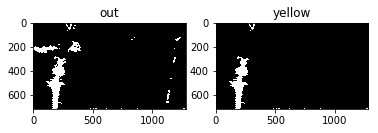

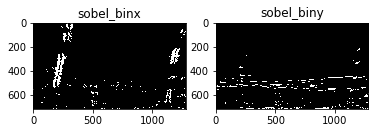

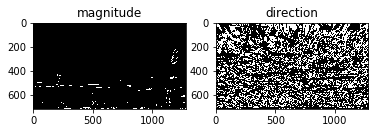

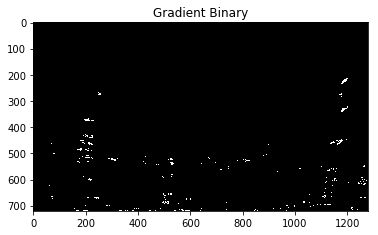

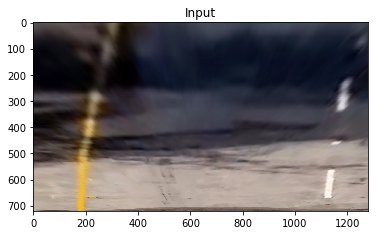

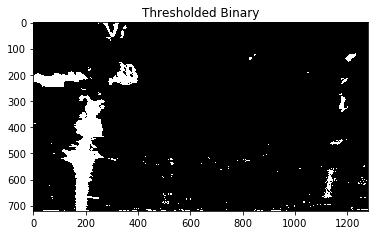

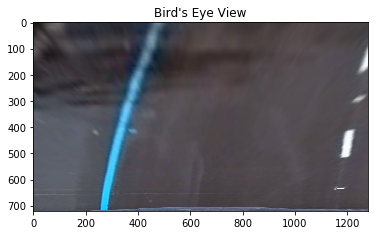

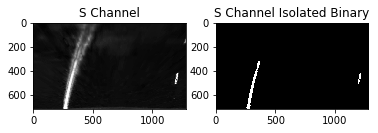

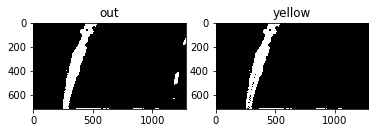

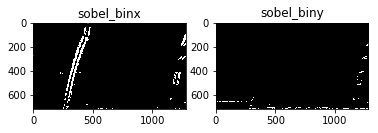

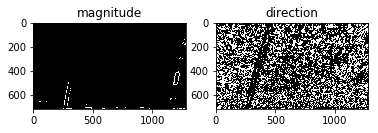

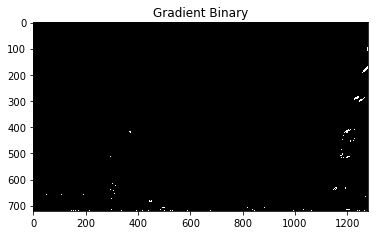

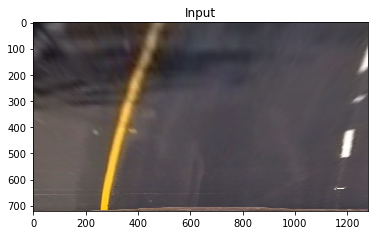

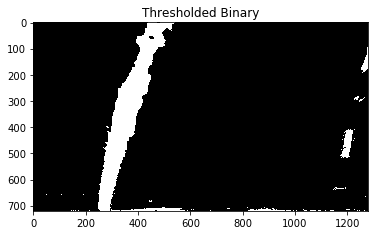

In [11]:
test_images = glob.glob('test_images/*.jpg')
birdseye_bgr = []
birdseye_bin = []
transformed_view = []

for file in test_images:
    img = cv2.imread(file)
    img = undistort_image(img, mtx, dist)
    
    threshold = transform_image(img, verbose = False)
    # transformed = perspective_transform(threshold, verbose = True)
    
    warped = perspective_transform(img, verbose = True)
    threshold2 = transform_image(warped, thresS = (180, 255), verbose = True)
    
    # histogram = Histogram(threshold2, 2)
    
    # plt.plot(histogram)
    # plt.show()
    
    transformed_view.append(threshold)
    birdseye_bin.append(threshold2)
    birdseye_bgr.append(warped)

# Lane Finding
This portion concerns finding the location of lanes in each image.

In [12]:
# making sure I have the right number of images
assert len(transformed_view) == len(birdseye_bin) == len(birdseye_bgr), "Length of transformed_view != Length of birdseye"

In [48]:
def Find_Lane_Start(binary, windows =9, margin = 100, minpix = 50, verbose = False):
    # plt.imshow(binary_warped, cmap = "gray")
    # plt.show()
    
    histogram = Histogram(binary, 2)
    # plt.plot(histogram)
    # plt.show()
    
    # Create an output image to draw on and  visualize the result
    drawing = (np.dstack((binary, binary, binary)) * 255).astype(np.uint8)
    # drawing = np.array(drawing)
    
    # print(drawing.shape)
    # print((drawing == [255, 255, 255]).sum(), "lane pixels")
    # print(drawing)
    
    # plt.imshow(drawing, cmap="gray")
    # plt.show()
        
    # splitting the histogram and finding the left and right starting pixels
    midpoint = np.int(histogram.shape[0] / 2)
    baseL = np.argmax(histogram[:midpoint])
    baseR = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows
    height = np.int(binary.shape[0] / windows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    currentL = baseL
    currentR = baseR
    
    # Create empty lists to receive left and right lane pixel indices
    leftLane = []
    rightLane = []

    # Step through the windows one by one
    for window in range(windows):
        # Identify window boundaries in x and y (and right and left)
        y_low = binary.shape[0] - (window + 1) * height
        y_high = binary.shape[0] - window * height
        
        xleft_low = currentL - margin
        xleft_high = currentL + margin
        
        xright_low = currentR - margin
        xright_high = currentR + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(drawing,(xleft_low, y_low),(xleft_high, y_high), (0,255,0), 2) 
        cv2.rectangle(drawing,(xright_low, y_low),(xright_high, y_high), (0,255,0), 2)
        
        # Identify the nonzero pixels in x and y within the window
        left = ((nonzeroy >= y_low) & (nonzeroy < y_high) & 
                (nonzerox >= xleft_low) & (nonzerox < xleft_high)).nonzero()[0]
        right = ((nonzeroy >= y_low) & (nonzeroy < y_high) & 
                 (nonzerox >= xright_low) & (nonzerox < xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        leftLane.append(left)
        rightLane.append(right)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(left) > minpix:
            currentL = np.int(np.mean(nonzerox[left]))
        if len(right) > minpix:        
            currentR = np.int(np.mean(nonzerox[right]))

    # Concatenate the arrays of indices
    leftLane = np.concatenate(leftLane)
    rightLane = np.concatenate(rightLane)

    # Extract left and right line pixel positions
    leftx = nonzerox[leftLane]
    lefty = nonzeroy[leftLane] 
    
    rightx = nonzerox[rightLane]
    righty = nonzeroy[rightLane] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return drawing, currentL, currentR, leftLane, rightLane, left_fit, right_fit, nonzerox, nonzeroy

def initialVisualize(binary, leftLane, rightLane, left_fit, right_fit, nonzerox, nonzeroy):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary.shape[0] - 1, binary.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    binary[nonzeroy[leftLane], nonzerox[leftLane]] = [255, 0, 0]
    binary[nonzeroy[rightLane], nonzerox[rightLane]] = [0, 0, 255]
    plt.imshow(binary)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.show()

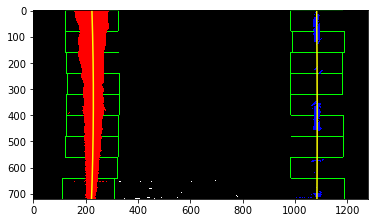

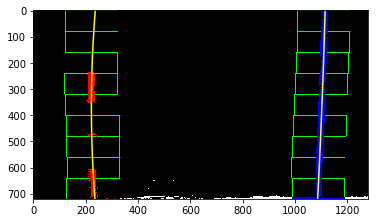

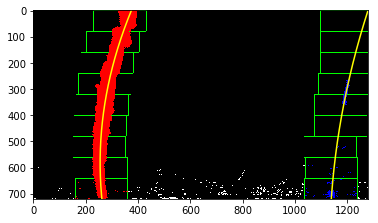

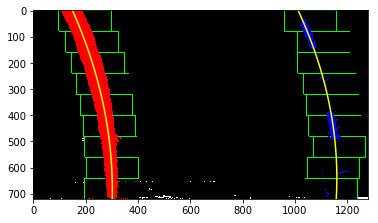

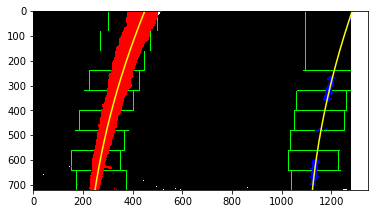

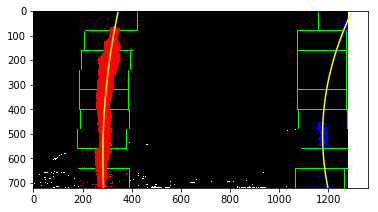

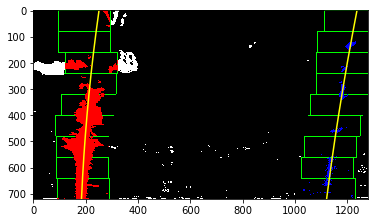

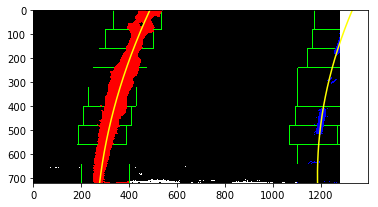

In [49]:

for img in birdseye_bin:
    drawing, currentL, currentR, leftLane, rightLane, left_fit, right_fit, nonzerox, nonzeroy = Find_Lane_Start(img, windows = 9, verbose=True)
    initialVisualize(drawing, leftLane, rightLane, left_fit, right_fit, nonzerox, nonzeroy)